Import pre-processed Numpy array of images and their corresponding labels from the local machine

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import numpy as np
link = 'https://drive.google.com/open?id=1Vjj9kCPW_tvBF4_C8inugmV-t3KiwBdX'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('X.npy')
X = np.load('X.npy')

In [0]:
import pandas as pd
link = 'https://drive.google.com/open?id=1nzSm7wBLln5k31alf_oL4zk5dzySCz3k'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('y.csv')
y = pd.read_csv("y.csv")

In [0]:
X_new = X[:16000]

In [0]:
X_new.shape

(16000, 224, 224, 3)

In [0]:
y_new = y[:16000]

In [0]:
y_new.shape

(16000, 2)

In [0]:
y_new = y_new.set_index("movie_id")

In [0]:
y_new.shape

(16000, 1)

Split the data into Train (Validation) & Test 

In [0]:
from sklearn.model_selection import train_test_split

print('Initial Dataset Size:', X_new.shape)
# create train and test datasets
train_X, test_X, train_y, test_y = train_test_split(X_new, y_new, 
                                                      test_size=0.2, 
                                                      random_state=42)
print('Initial Train and Test Datasets Size:', train_X.shape, test_X.shape)
# create train and validation datasets
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  test_size=0.4, 
                                                  random_state=42)
print('Train and Validation Datasets Size:', train_X.shape, val_X.shape)
print('Train, Test and Validation Datasets Size:', train_X.shape, test_X.shape, val_X.shape)
#get the length of the train and validation data
ntrain = len(train_X)
nval = len(val_X)

Initial Dataset Size: (16000, 224, 224, 3)
Initial Train and Test Datasets Size: (12800, 224, 224, 3) (3200, 224, 224, 3)
Train and Validation Datasets Size: (7680, 224, 224, 3) (5120, 224, 224, 3)
Train, Test and Validation Datasets Size: (7680, 224, 224, 3) (3200, 224, 224, 3) (5120, 224, 224, 3)


In [0]:
len(test_y)

3200

Import necessary packages from Keras

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as k
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

(224, 224, 3)


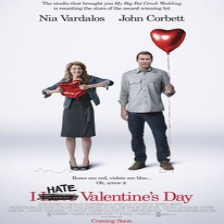

In [0]:
print(train_X[2534].shape)
array_to_img(train_X[2534])

Define parameters: the image input size (224, 224, 3) batch size, and epoch number

In [0]:
batch_size = 32
num_classes = 2
epochs = 50
input_shape = (224, 224, 3)

Scale the train and validation dataset for scenarios without image augmentation

In [0]:
train_X_scaled = train_X.astype('float32')
val_X_scaled  = val_X.astype('float32')
train_X_scaled /= 255
val_X_scaled /= 255

Simple CNN

In [0]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [0]:
history = model.fit(x=train_X_scaled, y=train_y,
                    validation_data=(val_X_scaled, val_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
240/240 [==============================] - 10s 42ms/step - loss: 0.9892 - accuracy: 0.5509 - val_loss: 0.7027 - val_accuracy: 0.5623
Epoch 2/15
240/240 [==============================] - 10s 41ms/step - loss: 0.6887 - accuracy: 0.5592 - val_loss: 0.6882 - val_accuracy: 0.5586
Epoch 3/15
240/240 [==============================] - 10s 42ms/step - loss: 0.6750 - accuracy: 0.5861 - val_loss: 0.6871 - val_accuracy: 0.5641
Epoch 4/15
240/240 [==============================] - 10s 42ms/step - loss: 0.6290 - accuracy: 0.6447 - val_loss: 0.7429 - val_accuracy: 0.5551
Epoch 5/15
240/240 [==============================] - 10s 42ms/step - loss: 0.5228 - accuracy: 0.7303 - val_loss: 0.8864 - val_accuracy: 0.5041
Epoch 6/15
240/240 [==============================] - 10s 42ms/step - loss: 0.3266 - accuracy: 0.8527 - val_loss: 1.2169 - val_accuracy: 0.5365
Epoch 7/15
240/240 [==============================] - 10s 42ms/step - loss: 0.1437 - accuracy: 0.9441 - val_loss: 1.7772 - val_accuracy:

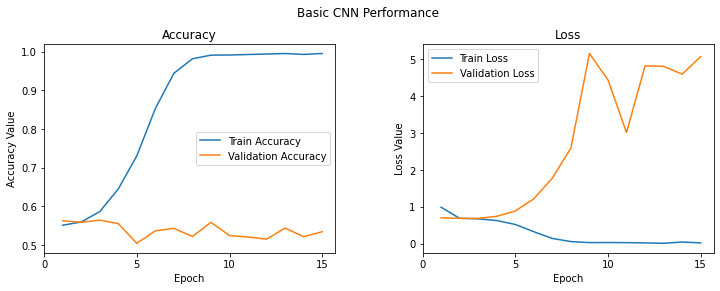

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,16))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 16, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 16, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Regularized CNN

In [0]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history2 = model.fit(x=train_X_scaled, y=train_y,
                    validation_data=(val_X_scaled, val_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)   

Epoch 1/15
240/240 [==============================] - 9s 37ms/step - loss: 0.7790 - accuracy: 0.5548 - val_loss: 0.6852 - val_accuracy: 0.5623
Epoch 2/15
240/240 [==============================] - 9s 37ms/step - loss: 0.6885 - accuracy: 0.5579 - val_loss: 0.6858 - val_accuracy: 0.5623
Epoch 3/15
240/240 [==============================] - 9s 37ms/step - loss: 0.6872 - accuracy: 0.5586 - val_loss: 0.6853 - val_accuracy: 0.5623
Epoch 4/15
240/240 [==============================] - 9s 37ms/step - loss: 0.6881 - accuracy: 0.5583 - val_loss: 0.6853 - val_accuracy: 0.5623
Epoch 5/15
240/240 [==============================] - 9s 37ms/step - loss: 0.6872 - accuracy: 0.5594 - val_loss: 0.6843 - val_accuracy: 0.5623
Epoch 6/15
240/240 [==============================] - 9s 37ms/step - loss: 0.6858 - accuracy: 0.5581 - val_loss: 0.6842 - val_accuracy: 0.5623
Epoch 7/15
240/240 [==============================] - 9s 37ms/step - loss: 0.6839 - accuracy: 0.5609 - val_loss: 0.6820 - val_accuracy: 0.5621

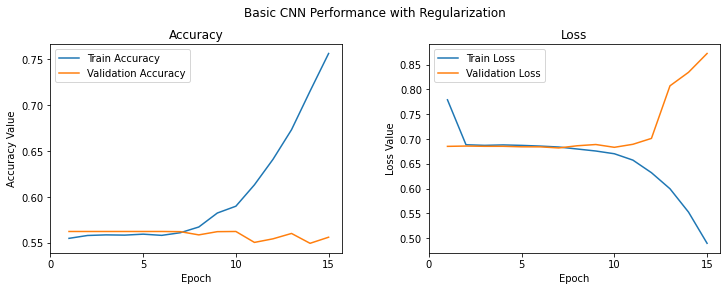

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance with Regularization', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,16))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 16, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 16, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Image Argumentation

In [0]:
# Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

#Create the image generators
train_generator = train_datagen.flow(train_X, train_y, batch_size=batch_size)
validation_generator = val_datagen.flow(val_X, val_y, batch_size=batch_size)
test_generator = val_datagen.flow(test_X, test_y, batch_size=batch_size)

Labels: [array([0]), array([0]), array([0]), array([0]), array([0])]


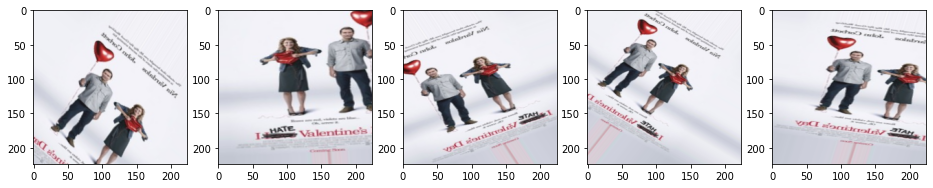

In [0]:
img_id = 2534
random_trial = train_datagen.flow(train_X[img_id:img_id+1], train_y[img_id:img_id+1],
                                   batch_size=1)
poster1 = [next(random_trial) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in poster1])
l = [ax[i].imshow(poster1[i][0][0]) for i in range(0,5)]

Labels: [array([1]), array([1]), array([1]), array([1]), array([1])]


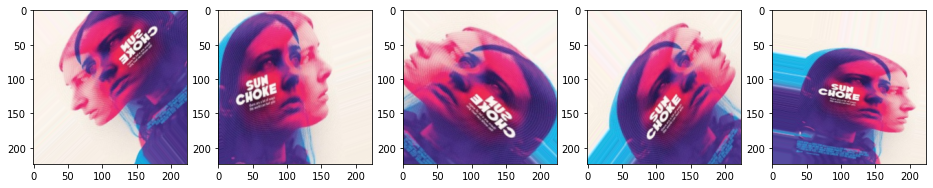

In [0]:
img_id = 6463
random_trial = train_datagen.flow(train_X[img_id:img_id+1], train_y[img_id:img_id+1],
                                   batch_size=1)
poster1 = [next(random_trial) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in poster1])
l = [ax[i].imshow(poster1[i][0][0]) for i in range(0,5)]

In [0]:
nb_train_samples = train_X.shape[0]
nb_val_samples = val_X.shape[0]
print(nb_train_samples)
print(nb_val_samples)

7680
5120


Regularized CNN with Image Augmentation

In [0]:
model3 = Sequential()

model3.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history3 = model3.fit_generator(train_generator, 
                                steps_per_epoch=nb_train_samples // batch_size, 
                                epochs=50,
                                validation_data=validation_generator, 
                                validation_steps=nb_val_samples // batch_size, 
                                verbose=1)  

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
240/240 [==============================] - 75s 313ms/step - loss: 0.6887 - accuracy: 0.5590 - val_loss: 0.6864 - val_accuracy: 0.5623
Epoch 2/50
240/240 [==============================] - 75s 313ms/step - loss: 0.6870 - accuracy: 0.5605 - val_loss: 0.6879 - val_accuracy: 0.5615
Epoch 3/50
240/240 [==============================] - 75s 310ms/step - loss: 0.6865 - accuracy: 0.5605 - val_loss: 0.6857 - val_accuracy: 0.5607
Epoch 4/50
240/240 [==============================] - 74s 310ms/step - loss: 0.6856 - accuracy: 0.5603 - val_loss: 0.6870 - val_accuracy: 0.5633
Epoch 5/50
240/240 [==============================] - 76s 316ms/step - loss: 0.6849 - accuracy: 0.5609 - val_loss: 0.6836 - val_accuracy: 0.5625
Epoch 6/50
240/240 [==============================] - 77s 319ms/step - loss: 0.6832 - accuracy: 0.5594 - val_loss: 0.6851 - val_accuracy: 0.5619
Epoch 7/50
240/240 [==============================] - 

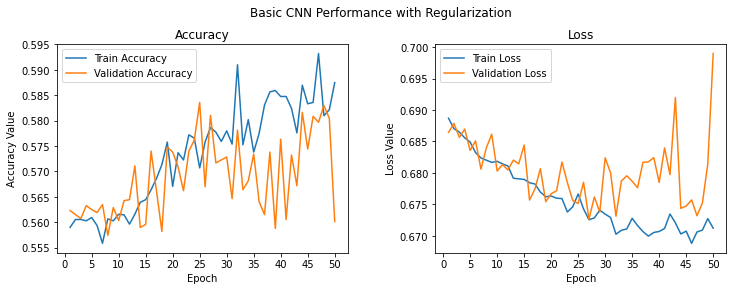

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance with Regularization', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model3.save(‘img_aug_cnn.h5’)

Leverage VGG-16 Model for Transfer learning purposes:

In [0]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

58892288/58889256 [==============================] - 1s 0us/step


1) First strategy: Using VGG-16 as feature extraction

In [0]:
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

58892288/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5c78411438>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5c78411a90>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5c78419240>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5c7878b198>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5ca0415f60>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5ca0115780>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5ca0198780>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5ca0198860>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5ca01929b0>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5ca0138748>,block3_conv3,False


(1, 7, 7, 512)


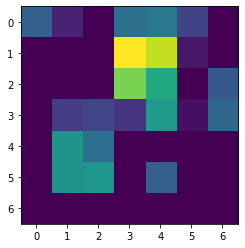

In [0]:
bottleneck_feature_example = vgg.predict(train_X_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [0]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_X_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, val_X_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (7680, 25088) 	Validation Bottleneck Features: (5120, 25088)


In [0]:
input_shape2 = vgg_model.output_shape[1]

model4 = Sequential()
model4.add(InputLayer(input_shape=(input_shape2,)))
model4.add(Dense(512, activation='relu', input_dim=input_shape2))
model4.add(Dropout(0.3))
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 13,108,737
Trainable params: 13,108,737
Non-trainable params: 0
_________________________________________________________________


In [0]:
history4 = model4.fit(x=train_features_vgg, y=train_y,
                    validation_data=(validation_features_vgg, val_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
240/240 [==============================] - 2s 8ms/step - loss: 0.7308 - accuracy: 0.5391 - val_loss: 0.6734 - val_accuracy: 0.5904
Epoch 2/15
240/240 [==============================] - 2s 8ms/step - loss: 0.6792 - accuracy: 0.5786 - val_loss: 0.6616 - val_accuracy: 0.6080
Epoch 3/15
240/240 [==============================] - 2s 8ms/step - loss: 0.6553 - accuracy: 0.6167 - val_loss: 0.6924 - val_accuracy: 0.5850
Epoch 4/15
240/240 [==============================] - 2s 7ms/step - loss: 0.6257 - accuracy: 0.6440 - val_loss: 0.6651 - val_accuracy: 0.6115
Epoch 5/15
240/240 [==============================] - 2s 7ms/step - loss: 0.5925 - accuracy: 0.6812 - val_loss: 0.6840 - val_accuracy: 0.5916
Epoch 6/15
240/240 [==============================] - 2s 7ms/step - loss: 0.5504 - accuracy: 0.7115 - val_loss: 0.7010 - val_accuracy: 0.6115
Epoch 7/15
240/240 [==============================] - 2s 7ms/step - loss: 0.4983 - accuracy: 0.7548 - val_loss: 0.7452 - val_accuracy: 0.5959
Epoch 

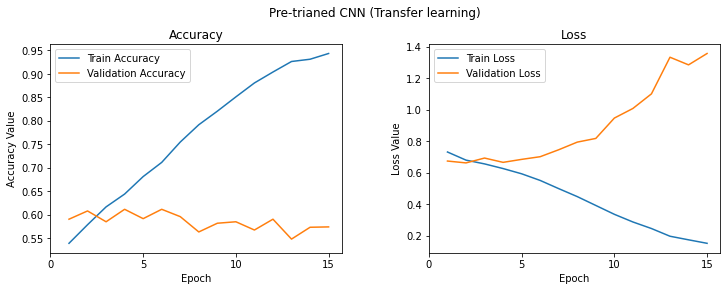

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trianed CNN (Transfer learning)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,16))
ax1.plot(epoch_list, history4.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history4.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 16, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history4.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 16, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

VGG-16 Feature extraction with image argumentation

In [0]:
model5 = Sequential()
model5.add(vgg_model)
model5.add(Dense(512, activation='relu', input_dim=input_shape2))
model5.add(Dropout(0.3))
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
history5 = model5.fit_generator(train_generator, 
                                steps_per_epoch=nb_train_samples // batch_size, 
                                epochs=50,
                                validation_data=validation_generator, 
                                validation_steps=nb_val_samples // batch_size, 
                                verbose=1)  

Epoch 1/50
240/240 [==============================] - 87s 363ms/step - loss: 0.7120 - accuracy: 0.5385 - val_loss: 0.6733 - val_accuracy: 0.5762
Epoch 2/50
240/240 [==============================] - 87s 361ms/step - loss: 0.6932 - accuracy: 0.5521 - val_loss: 0.6740 - val_accuracy: 0.5785
Epoch 3/50
240/240 [==============================] - 85s 353ms/step - loss: 0.6877 - accuracy: 0.5565 - val_loss: 0.6676 - val_accuracy: 0.6006
Epoch 4/50
240/240 [==============================] - 84s 352ms/step - loss: 0.6801 - accuracy: 0.5762 - val_loss: 0.6692 - val_accuracy: 0.5916
Epoch 5/50
240/240 [==============================] - 84s 351ms/step - loss: 0.6813 - accuracy: 0.5650 - val_loss: 0.6635 - val_accuracy: 0.6020
Epoch 6/50
240/240 [==============================] - 84s 352ms/step - loss: 0.6814 - accuracy: 0.5659 - val_loss: 0.6733 - val_accuracy: 0.5832
Epoch 7/50
240/240 [==============================] - 85s 354ms/step - loss: 0.6769 - accuracy: 0.5743 - val_loss: 0.6674 - val_ac

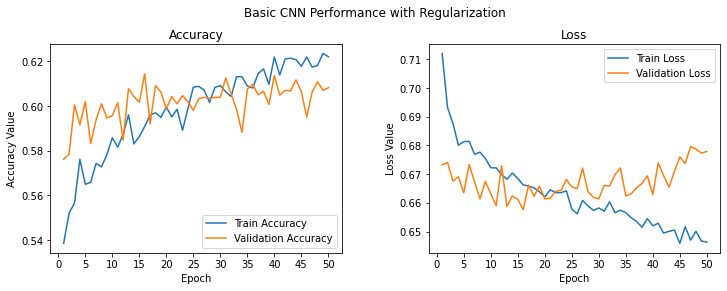

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance with Regularization', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history5.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history5.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history5.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history5.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
#Save the model
model5.save_weights('tlearn_img_aug_cnn.h5')

VGG-16 with Fine-tuning strategy (unfreeze block 4 and 5)

In [0]:
vgg_model.trainable = True
import pandas as pd
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [0]:
input_shape2 = vgg_model.output_shape[1]
model6 = Sequential()
model6.add(vgg_model)
model6.add(Dense(512, activation='relu', input_dim=input_shape2))
model6.add(Dropout(0.3))
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6),
              metrics=['accuracy'])

In [0]:
callbacks_list = [
tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
patience=5
),
tf.keras.callbacks.ModelCheckpoint(
filepath='tlearn_img_aug_finetune_cnn.h5',
monitor='accuracy',
save_best_only=True
),
tf.keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=3
)
]

In [0]:
history6 = model6.fit(train_generator, 
                      steps_per_epoch=7680 // batch_size, 
                      epochs=50,
                      validation_data=validation_generator, 
                      validation_steps=5120 // batch_size, 
                      callbacks=callbacks_list,
                      verbose=1) 

Epoch 1/50
240/240 [==============================] - 85s 353ms/step - loss: 0.7068 - accuracy: 0.5430 - val_loss: 0.6736 - val_accuracy: 0.5799 - lr: 1.0000e-06
Epoch 2/50
240/240 [==============================] - 85s 353ms/step - loss: 0.6979 - accuracy: 0.5487 - val_loss: 0.6681 - val_accuracy: 0.5836 - lr: 1.0000e-06
Epoch 3/50
240/240 [==============================] - 85s 355ms/step - loss: 0.6860 - accuracy: 0.5706 - val_loss: 0.6652 - val_accuracy: 0.5896 - lr: 1.0000e-06
Epoch 4/50
240/240 [==============================] - 85s 355ms/step - loss: 0.6773 - accuracy: 0.5814 - val_loss: 0.6705 - val_accuracy: 0.5775 - lr: 1.0000e-06
Epoch 5/50
240/240 [==============================] - 85s 353ms/step - loss: 0.6749 - accuracy: 0.5818 - val_loss: 0.6599 - val_accuracy: 0.6025 - lr: 1.0000e-06
Epoch 6/50
240/240 [==============================] - 85s 354ms/step - loss: 0.6722 - accuracy: 0.5910 - val_loss: 0.6592 - val_accuracy: 0.6072 - lr: 1.0000e-06
Epoch 7/50
240/240 [========

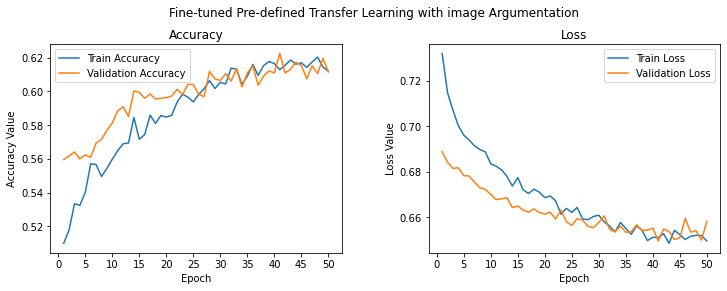

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Fine-tuned Pre-defined Transfer Learning with image Argumentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history6.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history6.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history6.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history6.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

InceptionResNetV2 without fine-tuning strategy

In [0]:
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

219062272/219055592 [==============================] - 4s 0us/step


In [0]:
conv_base.summary()

In [0]:
model7 = Sequential()
model7.add(conv_base)
model7.add(Flatten())
model7.add(Dense(512, activation='relu'))
model7.add(Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [0]:
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               19661312  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 73,998,561
Trainable params: 73,938,017
Non-trainable params: 60,544
_________________________________________________________________


In [0]:
model7.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [0]:
callbacks_list2 = [
tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
patience=5
),
tf.keras.callbacks.ModelCheckpoint(
filepath='inception_tlearn_cnn.h5',
monitor='accuracy',
save_best_only=True
),
tf.keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=3
)
]

In [0]:
#We train for 64 epochs with about 100 steps per epoch
history7 = model7.fit(train_generator, 
                    steps_per_epoch=7680 // batch_size, 
                    epochs=50,
                    validation_data=validation_generator, 
                    validation_steps=5120 // batch_size, 
                    callbacks=callbacks_list2,
                    verbose=1)

Epoch 1/50
240/240 [==============================] - 109s 454ms/step - loss: 0.6753 - accuracy: 0.5853 - val_loss: 0.6685 - val_accuracy: 0.5912 - lr: 2.0000e-05
Epoch 2/50
240/240 [==============================] - 106s 441ms/step - loss: 0.6666 - accuracy: 0.6000 - val_loss: 0.6760 - val_accuracy: 0.5994 - lr: 2.0000e-05
Epoch 3/50
240/240 [==============================] - 106s 442ms/step - loss: 0.6514 - accuracy: 0.6185 - val_loss: 0.6938 - val_accuracy: 0.6006 - lr: 2.0000e-05
Epoch 4/50
240/240 [==============================] - 106s 440ms/step - loss: 0.6427 - accuracy: 0.6303 - val_loss: 0.6991 - val_accuracy: 0.6078 - lr: 2.0000e-05
Epoch 5/50
240/240 [==============================] - 106s 442ms/step - loss: 0.6199 - accuracy: 0.6538 - val_loss: 0.6699 - val_accuracy: 0.6199 - lr: 2.0000e-06
Epoch 6/50
240/240 [==============================] - 106s 442ms/step - loss: 0.6160 - accuracy: 0.6595 - val_loss: 0.6692 - val_accuracy: 0.6203 - lr: 2.0000e-06
Epoch 7/50
240/240 [==

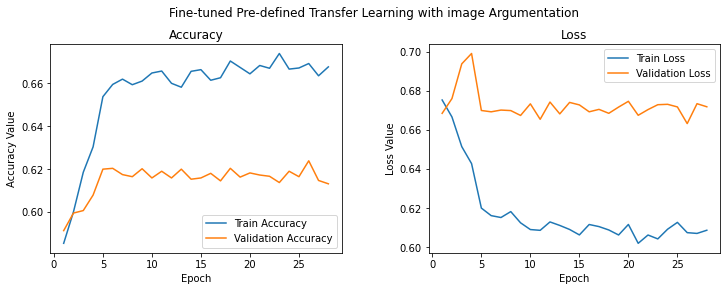

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Fine-tuned Pre-defined Transfer Learning with image Argumentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,29))
ax1.plot(epoch_list, history7.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history7.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 29, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history7.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history7.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 29, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
#Save the model
model.save_weights('inception_tlearn_cnn_wt.h5')
model.save('inception_tlearn_cnn.h5')

Further fine tune with Inception Pre-trained

In [0]:
incept_base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

output = incept_base.layers[-1].output

output = Flatten()(output)

incept_model = Model(incept_base.input, output)

# for layer in incept_model.layers[:4]:

#      layer.trainable = False

In [0]:
incept_model.trainable = True
import pandas as pd
set_trainable = False
for layer in incept_model.layers:
    if layer.name in ['block8_10']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in incept_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,False
1,<tensorflow.python.keras.layers.convolutional....,conv2d_203,False
2,<tensorflow.python.keras.layers.normalization_...,batch_normalization_203,False
3,<tensorflow.python.keras.layers.core.Activatio...,activation_203,False
4,<tensorflow.python.keras.layers.convolutional....,conv2d_204,False
...,...,...,...
776,<tensorflow.python.keras.layers.core.Lambda ob...,block8_10,True
777,<tensorflow.python.keras.layers.convolutional....,conv_7b,True
778,<tensorflow.python.keras.layers.normalization_...,conv_7b_bn,True
779,<tensorflow.python.keras.layers.core.Activatio...,conv_7b_ac,True


In [0]:
model8 = Sequential()
model8.add(incept_model)
model8.add(Dense(512, activation='relu', input_dim=input_shape))
model8.add(Dense(512, activation='relu'))
model8.add(Dense(2, activation='sigmoid')) 
model8.compile(loss='binary_crossentropy',
                optimizer=Adam(lr = 1e-6),
                metrics=['accuracy'])

In [0]:
callbacks_list3 = [
tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
patience=5
),
tf.keras.callbacks.ModelCheckpoint(
filepath='inception_finetune_tlearn_cnn.h5',
monitor='accuracy',
save_best_only=True
),
tf.keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=3
)
]

In [0]:
#We train for 64 epochs with about 100 steps per epoch
history8 = model8.fit(train_generator, 
                      steps_per_epoch=7680 // batch_size, 
                      epochs=50,
                      validation_data=validation_generator, 
                      validation_steps=5120 // batch_size, 
                      callbacks=callbacks_list3,
                      verbose=1)

Epoch 1/50
240/240 [==============================] - 98s 409ms/step - loss: 0.7056 - accuracy: 0.4794 - val_loss: 0.6976 - val_accuracy: 0.4461 - lr: 1.0000e-06
Epoch 2/50
240/240 [==============================] - 95s 398ms/step - loss: 0.6939 - accuracy: 0.4918 - val_loss: 0.6918 - val_accuracy: 0.4844 - lr: 1.0000e-06
Epoch 3/50
240/240 [==============================] - 96s 399ms/step - loss: 0.6851 - accuracy: 0.4992 - val_loss: 0.6828 - val_accuracy: 0.4775 - lr: 1.0000e-06
Epoch 4/50
240/240 [==============================] - 94s 391ms/step - loss: 0.6815 - accuracy: 0.4975 - val_loss: 0.6838 - val_accuracy: 0.4904 - lr: 1.0000e-06
Epoch 5/50
240/240 [==============================] - 93s 389ms/step - loss: 0.6775 - accuracy: 0.4973 - val_loss: 0.6784 - val_accuracy: 0.5074 - lr: 1.0000e-06
Epoch 6/50
240/240 [==============================] - 95s 398ms/step - loss: 0.6738 - accuracy: 0.5017 - val_loss: 0.6796 - val_accuracy: 0.5162 - lr: 1.0000e-06
Epoch 7/50
240/240 [========

Visualization intermediate activations

Reload our best model

In [0]:
import tensorflow as tf
link = 'https://drive.google.com/open?id=1-1PF3lXdK0y4xXskOR1xSH3tlqnQV6Eg'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tlearn_img_aug_finetune_cnn.h5')
final_model = tf.keras.models.load_model('tlearn_img_aug_finetune_cnn.h5')

In [0]:
# Show the model architecture
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 25088)             14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 27,823,425
Trainable params: 26,087,937
Non-trainable params: 1,735,488
__________________________________

In [0]:
num2class_label_transformer = lambda l: ['Rotten' if x == 0 else 'Fresh' for x in l]
test_X  = test_X.astype('float32')
test_X_scaled = test_X / 255
# getting model predictions
test_predictions = final_model.predict_classes(test_X_scaled, verbose=0)
test_labels = num2class_label_transformer(test_y.tomatometer_status)
predictions = num2class_label_transformer(test_predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [0]:
len(test_labels)

3200

In [0]:
test_labels = num2class_label_transformer(test_labels)

In [0]:
len(predictions)

3200

In [0]:
!pip install protobuf

In [0]:
display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions,classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.6234
Precision: 0.6135
Recall: 0.6234
F1 Score: 0.6082

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       Fresh       0.65      0.79      0.71      1870
      Rotten       0.57      0.40      0.47      1330

    accuracy                           0.62      3200
   macro avg       0.61      0.59      0.59      3200
weighted avg       0.61      0.62      0.61      3200


Prediction Confusion Matrix:
------------------------------


TypeError: ignored

Instructions for updating:
Please use `model.predict()` instead.


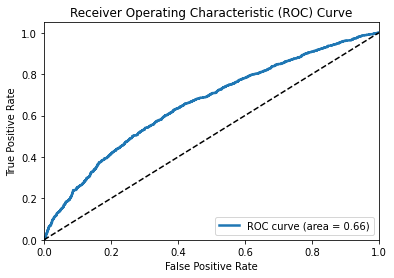

In [0]:
plot_model_roc_curve(final_model, test_X_scaled, 
                         true_labels=test_y.tomatometer_status, 
                         class_names=[0, 1]) 

ReceptionV3 Model without fine-tuning

In [0]:
#------------------------------------------
#Creating InceptionV3 model and training it
#------------------------------------------

inp = Input(IMG_SIZE)
inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp, input_shape=IMG_SIZE, pooling='avg')
x = inception.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
out = Dense(1, activation='sigmoid')(x)

complete_model = Model(inp, out)

complete_model.compile(loss='binary_crossentropy',
                        optimizer=Adam(lr = 1e-6),
                        metrics=['accuracy'])
print (complete_model.summary())

history = complete_model.fit(train_generator, 
                              steps_per_epoch=7680 // BATCH_SIZE, 
                              epochs=50,
                              validation_data=validation_generator, 
                              validation_steps=5120 // BATCH_SIZE, 
                              verbose=1)
print ("Saving history...")



Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

NameError: ignored

In [0]:
import pickle
with open('inceptionv3_histobject', 'wb') as fi:
    pickle.dump(history.history, fi)

complete_model.save('inceptionv3.h5')

In [0]:
import tensorflow as tf
link = 'https://drive.google.com/open?id=1ix82oAB9n2ORymq4vPwnvFGrXV6CXOBn'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('inceptionv3.h5')
complete_model = tf.keras.models.load_model('inceptionv3.h5')

In [0]:
#---------------------------------------------------------------------------------------
#Getting outputs for intermediate convolution layers by running prediction on test image
#---------------------------------------------------------------------------------------

layer_outputs = [layer.output for layer in complete_model.layers[:50]]
test_X  = test_X.astype('float32')
img_tensor = test_X[643]
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

activation_model = Model(inputs=complete_model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[1], activations[3], activations[11], activations[13], activations[18], activations[20]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')

Output hidden; open in https://colab.research.google.com to view.

Deliver useful insights of the model output

Class Activation Maps

In [0]:
gap_weights = complete_model.layers[-1].get_weights()[0]
gap_weights.shape

(256, 1)

In [0]:
gap_weights2 = complete_model.layers[-3].get_weights()[0]
gap_weights2.shape

(2048, 256)

In [0]:
gap_weights3 = np.dot(gap_weights2,gap_weights)
gap_weights3.shape

(2048, 1)

In [0]:
test_X  = test_X.astype('float32')

In [0]:
test_X /= 255

In [0]:
cam_model  = Model(inputs=complete_model.input,outputs=(complete_model.layers[-5].output,complete_model.layers[-1].output))

In [0]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [0]:

features,results = cam_model.predict(test_X)
features.shape

(3200, 5, 5, 2048)

In [0]:
results.shape

(3200, 1)

In [0]:
results[888]

array([0.5501909], dtype=float32)

In [0]:
import pandas as pd
results_ready = pd.DataFrame(results, columns=['proba'])
results_ready.shape

(3200, 1)

In [0]:
results_ready.reset_index()

,index,proba
0,0,0.355016
1,1,0.550042
2,2,0.626639
3,3,0.692231
4,4,0.538013
...,...,...
3195,3195,0.686000
3196,3196,0.527893
3197,3197,0.372651
3198,3198,0.460954


In [0]:
results_sorted = results_ready.sort_values(by='proba', ascending=False)
print(results_sorted.head(10))
print(results_sorted.tail(10))

         proba
2866  0.952504
196   0.936731
2889  0.926096
982   0.922535
2833  0.921497
3008  0.917669
201   0.917641
783   0.916884
2051  0.910531
669   0.910460
         proba
2386  0.176969
512   0.176869
100   0.175694
1960  0.175478
1219  0.173221
3080  0.170973
1922  0.158680
88    0.157213
309   0.153443
1287  0.151724


Predicted rotten posters

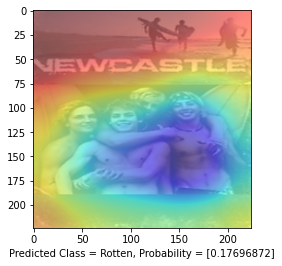

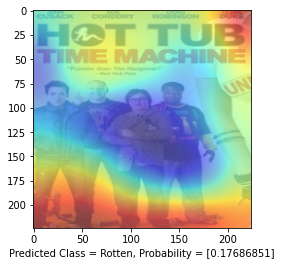

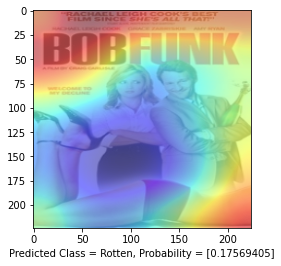

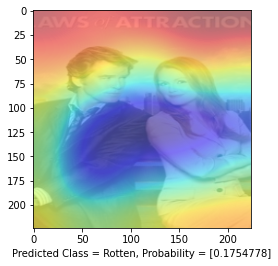

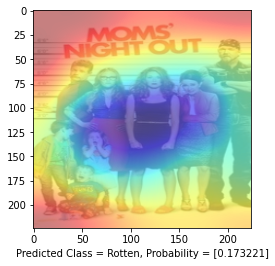

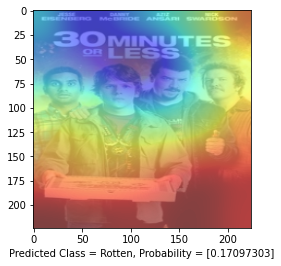

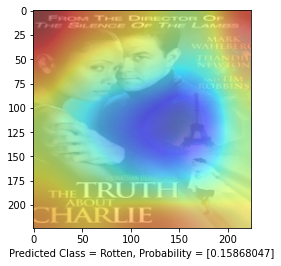

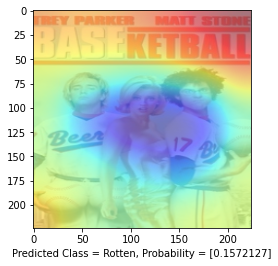

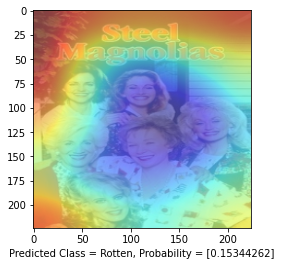

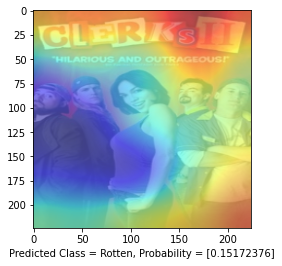

In [0]:
import scipy as sp
for idx in [2386, 512, 100, 1960, 1219, 3080, 1922, 88, 309, 1287]:
    features_for_one_img = features[idx,:,:,:]
    height_roomout = train_X.shape[1]/features_for_one_img.shape[0]
    width_roomout  = train_X.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    # pred = np.argmax(results[idx])
    if results[idx]<0.5:
      pred = 'Rotten'
    else:
      pred = 'Fresh'

    plt.figure(facecolor='white')
    cam_weights = gap_weights3[:,0]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' + pred + ', Probability = ' + str(results[idx])

    plt.xlabel(buf)

    plt.imshow(test_X[idx], alpha=0.5)

    plt.imshow(cam_output, cmap='jet', alpha=0.5)

    plt.show()

Predicted Fresh posters

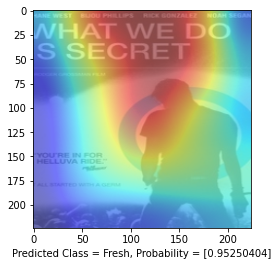

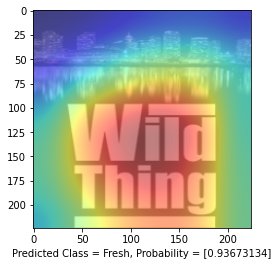

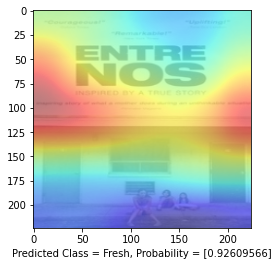

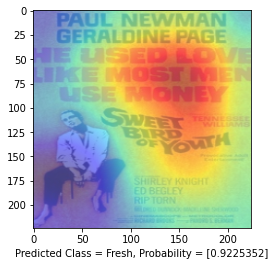

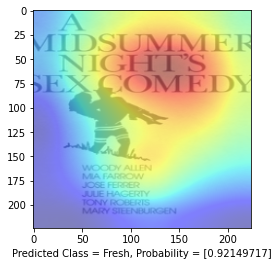

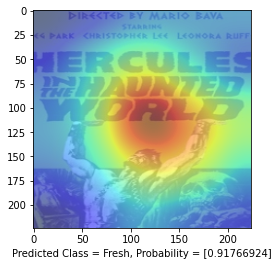

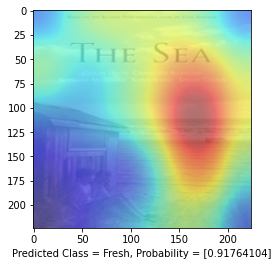

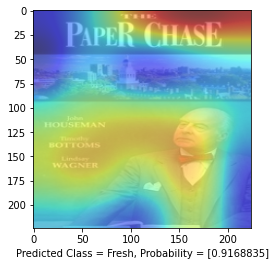

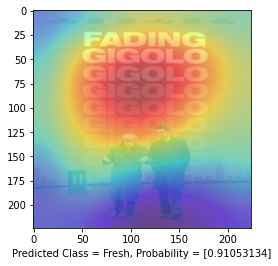

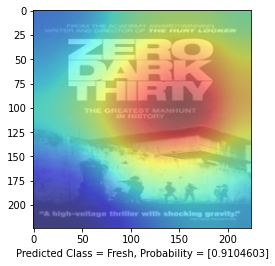

In [0]:
import scipy as sp
for idx in [2866, 196, 2889, 982, 2833, 3008, 201, 783, 2051, 669]:
    features_for_one_img = features[idx,:,:,:]
    height_roomout = train_X.shape[1]/features_for_one_img.shape[0]
    width_roomout  = train_X.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    # pred = np.argmax(results[idx])
    if results[idx]<0.5:
      pred = 'Rotten'
    else:
      pred = 'Fresh'
    plt.figure(facecolor='white')
    cam_weights = gap_weights3[:,0]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' + pred + ', Probability = ' + str(results[idx])

    plt.xlabel(buf)

    plt.imshow(test_X[idx], alpha=0.5)

    plt.imshow(cam_output, cmap='jet', alpha=0.5)

    plt.show()

In [0]:
import scipy as sp
for idx in list(range(0, 3199)):
    features_for_one_img = features[idx,:,:,:]
    height_roomout = train_X.shape[1]/features_for_one_img.shape[0]
    width_roomout  = train_X.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    # pred = np.argmax(results[idx])
    if results[idx]<0.5:
      pred = 'Rotten'
    else:
      pred = 'Fresh'
    if (results[idx]>0.8) or (results[idx]<0.2):
      plt.figure(facecolor='white')
      cam_weights = gap_weights3[:,0]
      cam_output  = np.dot(cam_features,cam_weights)
      #print(features_for_one_img.shape)

      buf = 'Predicted Class = ' + pred + ', Probability = ' + str(results[idx])

      plt.xlabel(buf)

      plt.imshow(test_X[idx], alpha=0.5)

      plt.imshow(cam_output, cmap='jet', alpha=0.5)

      plt.show()

Output hidden; open in https://colab.research.google.com to view.